# Introduction

In this tutorial, we will implement synchronous value iteration and Q-learning adapted to the options framework.

To read more details about the options framework before doing these exercises, read the paper by Sutton et al.: http://www.sciencedirect.com/science/article/pii/S0004370299000521

# Notebook setup

## Instructions

- Import numpy, scipy and matplotlib
- Configure inline plots
- Import helper modules

In [11]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

# Import definitions of the environments.
import RL_worlds as worlds

# Import helper functions for plotting.
from plot_util import *

In [12]:
def init_state(params):
    return np.random.randint(params["environment"].n_states - 4)

def update_state(state, option, params):
    next_state, reward = params['environment'].get_outcome(state, option)
    return next_state, reward

def default_params(environment):
    params = dict()
    params['environment'] = environment
    params['alpha'] = 0.1  # learning rate     
    params['epsilon'] = 0.05  # epsilon-greedy policy
    params['gamma'] = 0.9  # temporal discount factor
    return params

def epsilon_greedy(state, value, params):
    if np.random.rand() < 1 - params["epsilon"]: 
        a = argmax(value[state, :])
    else:
        a = np.random.randint(params["environment"].n_options)
    return a

In [115]:
def index2state(i, j):
    if i < 5 and j < 5:
        state = 5 * i + j
    elif i > 5 and j < 5:
        state = 25 + 5 * (i - 5 - 1) + j
    elif i < 6 and j > 5:
        state = 50 + 5 * i + (j - 5 - 1)
    elif i > 6 and j > 5:
        state = 80 + 5 * (i - 6 - 1) + (j - 5 - 1)
    elif i == 5 and j == 1:
        state = 100
    elif i == 9 and j == 5:
        state = 101
    elif i == 2 and j == 5:
        state = 102
    elif i == 6 and j == 8:
        state = 103
    else:
        state = 0
    return state

In [116]:
def plot_smdp(Q):
    V = np.max(Q, axis = 1)
    V = V / np.max(V)
    A = np.zeros((11, 11))
    A[:5, :5] = 1
    A[6:, :5] = 1
    A[:6, 6:] = 1
    A[7:, 6:] = 1
    A[5, 1] = 1
    A[2, 5] = 1
    A[9, 5] = 1
    A[6, 8] = 1
    plt.pcolor(flipud(A), cmap = "gray")

    for i in range(11):
            plt.vlines(i, 0, 11)
            plt.hlines(i, 0, 11)

    for i in range(11):
        for j in range(11):
            state = index2state(i, j)
            circle = plt.Circle((i + 0.5, j + 0.5), V[state] * 0.5, color='black')
            plt.gca().add_artist(circle)

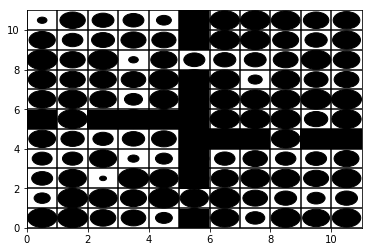

In [117]:
Q = np.random.rand(104, 4)
plot_smdp(Q)

# Exercise 1: multi-room grid world

1. Implement a 4-room grid world like the one in page 194 of the article. You can do this by extending class *world* from the RL_worlds module. Use only primitive (single-step) options (i.e., simple actions).
Tip: you can implement a new class called option to represent options in general, including single-step ones. This class will include an initiation set $I$, a termination condition $\beta$, and a policy $\pi$ associated with the option.

2. Modify the environment to also include multi-step options that can go from anywhere inside a room into one of that room's two hallways, as described in the paper.

In [124]:
class option:
    def __init__(self, I, beta, policy):
        self.I = I
        self.beta = beta
        self.policy = policy

In [125]:
o = option([1, 2], 3, [])

In [ ]:
class grid_ylh(world):
    def __init__(self):
        self.name = "windy_cliff_grid"
        self.n_states = 104
        self.n_actions = 4
        self.dim_x = 11
        self.dim_y = 11

In [123]:
class multi_room_grid(world):
    def __init__(self):
        self.name = "multi_room_grid"
        self.n_states = 104
        self.n_actions = 4
        self.n_options = 4 + 8
        self.options = []

    def get_action_outcome(self, state, action):
        state = state - 1
        next_state = None
        reward = 0
        #if state in [88]:  # end of MDP
        #    return next_state, reward
        if action == 0:  # move right
            next_state = state + 1
            if state == 87:  # goal state 
                reward = 1           
            elif state in [5,10,20,25,30,35,40,45,50,55,60,65,70,80,85,90,95,100]:  # cliff
                next_state = state
            elif state == 15:
                next_state = 101
            elif state == 75:
                next_state = 103		
        elif action == 1:  # move up
            next_state = state - 5
            if state == 93: # goal state
                reward = 1
            elif state in [1,2,3,4,5,26,27,28,29,30,56,58,59,60,81,82,84,85]:  # cliff
                next_state = state
            elif state == 57:
                next_state = 102
            elif state == 83:
                next_state = 104
        elif action == 2:  # move left
            next_state = state - 1
            if state == 89:  # goal state
                reward = 1
            elif state in [1,6,11,16,21,56,61,66,71,76,26,31,41,46,51,81,86,96]:  # cliff
                next_state = state
            elif state == 36: 
                next_state = 101
            elif state == 91
                next_state = 103
        elif action == 3:  # move down
            next_state = state + 5
            if state == 83:  # goal state 
                reward = 1
            elif state in [21,23,24,25,51,52,54,55,76,77,78,79,80,96,97,98,99,100]:
                next_state = state
            elif state == 22:
                next_state = 102
            elif state == 53:
                next_state = 104
        else:
            print("Action must be between 0 and 3.")
            next_state = None
            reward = None
        return int(next_state-1) if next_state-1 is not None else None, reward

    def get_outcome(self, params, state, option):
        o = self.options[option]
        total_reward, step = 0, 0
        while not o.termination(state):
            action = argmax(o.policy[state, :])
            state, reward = self.get_action_outcome(state, action)
            total_reward = total_reward * params["gamma"] + reward
            step += 1
        int(state) if state is not None else None, total_reward, step

NameError: name 'world' is not defined

# Exercise 2: SMDP learning

1. Implement a learning method for the SMDP using modified Q-learning (page 195).

2. Replicate the results shown in the paper, using both multi-step and single-step options (Fig. 5).

In [ ]:
def smdp_learning(params, n_episodes = 500, n_steps = 1000):
    env = params["environment"]
    value = np.zeros((env.n_states, env.n_options))
    rewards = []
    for episode in range(n_episodes):
        state = init_state(params)
        reward_sum = 0
        for step in range(n_steps):
            option = epsilon_greedy(state, value, params)
            next_state, reward = update_state(state, option, params)
            reward_sum += reward
            value = smdp_q_learning(state, option, reward, next_state, value, params)  
            state = next_state
            if next_state == None: break
        rewards.append(reward_sum)
    return value, rewards

In [ ]:
def smdp_q_learning(state, option, reward, next_state, value, params):
    max_value = max(value[next_state,:]) if next_state is not None else 0
    k = 1 #option.kk()
    delta = reward + params["gamma"]**k * max_value - value[state, option]
    value[state, option] += params["alpha"] * delta
    return value

In [45]:
params = default_params(multi_room_grid())
params["epsilon"] = 0.1
params["alpha"] = 0.3
value, rewards = smdp_learning(params)
plot_smdp(Q)
plt.plot(rewards)

NameError: name 'multi_room_grid' is not defined

# Exercise 3: SMDP planning

1. Implement a planning method for the SMDP using synchronous value iteration (page 191).

2. Replicate the results shown in the paper, including the comparison between using multi-step only options vs. including single-step options (Fig. 4).

In [50]:
def smdp_planning(params, theta = 1e-4):
    delta = 1e10
    env = params["environment"]
    Q = np.zeros((world.n_states, world.n_options))
    while delta > theta:
        Q_new = np.zeros_like(Q)
        for state in range(env.n_states):
            for option in range(env.n_options):
                next_state, reward = update_state(state, option, params)
                k = 1 # option.kk()
                Q_new[state, option] = reward + paras["gamma"]**k * max(Q[next_state, o] for o in range(world.n_options))
        delta = np.linalg.norm(Q - Q_new, ord = inf)
        np.copyto(Q, Q_new)
    return Q

In [ ]:
params = default_params(multi_room_grid())
params["gamma"] = 0.99
Q = smdp_planning(params)
plot_smdp(Q)